### Setting up and retrieving data

#### Imports
Performing the necessary imports for the file to run. Main imports that are used are as follows:
- pandas/numpy: Working with data
- transformers: BERT Tokenizer
- keras: Model Architecture
- matplotlib: Visualisation of performance
- sklearn: Evaluation

In [25]:
import os
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, TFBertModel

import tensorflow as tf

# from keras.layers import Layer

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score

In [26]:
# Hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EPOCHS = 10
BATCH_SIZE = 16
LSTM_UNITS = 64

# Set a seed to decrease randomness
SEED = 42
tf.random.set_seed(SEED)

# Set the glove file to refer to
MODEL_NAME = 'bert-base-uncased'
TOKENIZER_NAME = 'bilstm.' + MODEL_NAME + '.tokenizer.json'
SAVED_NAME = 'bilstm.' + MODEL_NAME + '.keras'
WEIGHTS_FILE = 'bilstm.'+ MODEL_NAME +'.weights.h5'

#### Load CSV files
Loading CSV files from the train and dev csv for preprocessing

In [27]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('dev.csv')

#### Set up BERT-based Tokenizer
Instantiates the tokenizer based on the model name above and define functions for encoding sentences

In [28]:
# Instantiate Tokenizer on MODEL_NAME (BERT)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Encodes sentence
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

# Encode data for the bert model with a max length of MAX_SEQUENCE_LENGTH
def bert_encode(hypotheses, premises, tokenizer, max_length=MAX_SEQUENCE_LENGTH):

    x = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]
    x = tokenizer(x, padding=True, truncation=True, max_length=max_length)

    inputs = {
          'input_word_ids':tf.ragged.constant(x['input_ids']).to_tensor(),
          'input_mask': tf.ragged.constant(x['attention_mask']).to_tensor(),
          'input_type_ids': tf.ragged.constant(x['token_type_ids']).to_tensor()}

    return inputs

In [29]:
# Encode train inputs
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [30]:
# Encode both train and valid inputs
valid_input = bert_encode(valid.premise.values, valid.hypothesis.values, tokenizer)

### Model Architecture


In [31]:
os.environ["WANDB_API_KEY"] = "0"

# Defining an attention class
# class Attention(Layer):
#     def __init__(self, **kwargs):
#         super(Attention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal", trainable=True)
#         self.b = self.add_weight(name="att_bias", shape=(1,), initializer="zeros", trainable=True)
#         super(Attention, self).build(input_shape)

#     def call(self, inputs):
#         e = K.tanh(K.dot(inputs, self.W) + self.b)  # Compute attention scores
#         a = K.softmax(e, axis=1)  # Softmax over time axis
#         output = inputs * a  # Apply attention weights
#         return K.sum(output, axis=1)  # Weighted sum over time axis

# Define function to build the model
def build_model():
    # BERT encoder layer that is non-trainable
    bert_encoder = TFBertModel.from_pretrained(MODEL_NAME, trainable=False)

    # Tokenized input sequence (word indices), Mask to indicate real tokens/padding, Type Ids
    input_word_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_type_ids")

    # Encodes all 3 inputs
    output = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]

    # BiLSTM layer and normalisation to prevent overfitting.
    output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS))(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    output = tf.keras.layers.Dense(64, activation='relu')(output)
    output = tf.keras.layers.BatchNormalization()(output)
    output = tf.keras.layers.Dropout(0.1)(output)

    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    # Returns the model
    return tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)

# Builds the model
model = build_model()
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                            

In [32]:
# Compiles the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Setting up Early Stopping with callback to checkpoint for the training of the model which monitors val loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)
checkpoint_filepath = WEIGHTS_FILE

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True)

### Training the model
Firstly, creating tensorflow datasets from both the training and validation set. Then, proceed to fit the model.

In [34]:
# Create a TensorFlow dataset from the training data and shuffles them with seed=42
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train.label.values.reshape(-1,1)))
train_dataset = train_dataset.shuffle(SEED, reshuffle_each_iteration=True).batch(BATCH_SIZE)

# Create a TensorFlow dataset from the valid data and batch them up
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input, valid.label.values.reshape(-1,1)))
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [35]:
# Fitting the model
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    validation_data = valid_dataset,
    callbacks=[early_stopping, model_checkpoint_callback]
)

# Saving the model
model.save(SAVED_NAME)

Epoch 1/10
1527/1527 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.5980

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1527/1527 [==============================] - 312s 193ms/step - loss: 0.6786 - accuracy: 0.5980 - val_loss: 0.6633 - val_accuracy: 0.6140
Epoch 2/10
1527/1527 [==============================] - 256s 168ms/step - loss: 0.6200 - accuracy: 0.6559 - val_loss: 0.6652 - val_accuracy: 0.6254
Epoch 3/10
1527/1527 [==============================] - 258s 169ms/step - loss: 0.5831 - accuracy: 0.6925 - val_loss: 0.5774 - val_accuracy: 0.6939
Epoch 4/10
1527/1527 [==============================] - 251s 164ms/step - loss: 0.5556 - accuracy: 0.7130 - val_loss: 0.5962 - val_accuracy: 0.6779
Epoch 5/10
1527/1527 [==============================] - 250s 164ms/step - loss: 0.5296 - accuracy: 0.7374 - val_loss: 0.5873 - val_accuracy: 0.6923
Epoch 6/10
1527/1527 [==============================] - 257s 168ms/step - loss: 0.5062 - accuracy: 0.7537 - val_loss: 0.6091 - val_accuracy: 0.7006


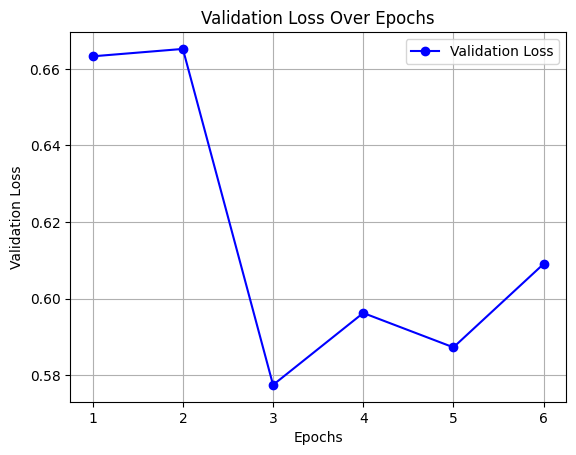

In [36]:
# Visualisation of the performance of the val loss across epoch
val_loss = history.history['val_loss']

# Plot the validation loss over epochs
plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', linestyle='-', color='b', label="Validation Loss")

# Labeling the graph
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Predicting using the model

In [39]:
# Load the entire model in
test_model = tf.keras.models.load_model(SAVED_NAME, custom_objects={'TFBertModel': TFBertModel})
# model.load_weights('best.model.weights.h5')

# Use the model to predict the valid input
outputs = test_model.predict(valid_input)

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


211/211 [==============================] - 51s 222ms/step


In [40]:
# Convert probabilities to classes and reshape
preds = outputs > 0.5
labels = valid.label.values.reshape(-1,1)

# Evaluate results
print(f"Accuracy: {accuracy_score(labels, preds):.4f}")
print(f"F1 Score: {f1_score(labels, preds):.4f}")
print(f"Precision: {precision_score(labels, preds):.4f}")
print(f"Recall: {recall_score(labels, preds):.4f}")
print(f"MCC: {matthews_corrcoef(labels, preds):.4f}")
print(f"ROC AUC Score: {roc_auc_score(labels, preds):.4f}")

Accuracy: 0.7006
F1 Score: 0.6633
Precision: 0.7907
Recall: 0.5713
MCC: 0.4235
ROC AUC Score: 0.7049
